# Plotting Individual Bee Identification over time
Gregory Glatzer | The Pennsylvania State University

11/10/2022

In [183]:
from datetime import datetime
import plotly.express as px
import pandas as pd

def load_logs(log_file: str):

    with open(log_file, "r") as f:
        lines = f.readlines()

        logs = []
        for line in lines:
            if "detected at" not in line:
                continue

            bee_id = int(line.split("=")[1].split(" ")[0])
            timestamp = datetime.strptime(line.split(" ")[-1].strip(), "%H:%M:%S")
            logs.append({
                "bee_id": bee_id,
                "timestamp": timestamp
            })

    return pd.DataFrame(logs)

def parse_log(log, verbose=True) -> pd.DataFrame:

    with open(log, "r") as f:
        lines = f.readlines()

    logs = []

    for line in lines:
        if "detected at" not in line:
            continue

        bee_id = int(line.split("=")[1].split(" ")[0])
        timestamp_to_parse = line.split(" ")[-1].strip()

        ####################
        # clean timestamps #
        ####################
        
        if len(timestamp_to_parse) < 5:
            # there just isn't enough to parse
            if verbose:
                print("Dropping row with insufficient timestamp:", timestamp_to_parse)
            continue

        edited_timestamp = False

        if ":" not in timestamp_to_parse:
            # add missing colons
            timestamp_to_parse = timestamp_to_parse[:2] + ":" + timestamp_to_parse[2:4] + ":" + timestamp_to_parse[4:]
            edited_timestamp = True

        if timestamp_to_parse.count(":") == 1:
            edited_timestamp = True
            chars_after_colon = timestamp_to_parse.split(":")[1]
            if len(chars_after_colon) == 3:
                # add zero
                chars_after_colon = chars_after_colon[:2] + ":" + chars_after_colon[2] + "0"
            elif len(chars_after_colon) == 2:
                # add missing seconds
                chars_after_colon = chars_after_colon + ":00"
            elif len(chars_after_colon) == 1:
                # add missing seconds and minutes
                chars_after_colon = "0:00" + chars_after_colon
            else:
                chars_after_colon = chars_after_colon[:2] + ":" + chars_after_colon[2:]

            timestamp_to_parse = timestamp_to_parse.split(":")[0] + ":" + chars_after_colon
        
        # parse
        timestamp_to_parse = timestamp_to_parse[:8]
        try:
            timestamp = datetime.strptime(timestamp_to_parse, "%H:%M:%S")
        except ValueError:
            if verbose:
                print("Unable to parse timestamp:", timestamp_to_parse)
            continue

        logs.append({
            "bee_id": bee_id,
            "timestamp": timestamp,
            "timestamp was edited": edited_timestamp
        })
        
    df = pd.DataFrame(logs)
    df["timestamp"] = df["timestamp"]
    return df


def plot_timestamps_per_bee_ID(timestamps, renderer="browser"):
    timestamps["timestamp"] = timestamps["timestamp"].dt.strftime('%H:%M:%S')
    fig = px.scatter(
        timestamps, 
        x="timestamp", 
        y="bee_id", 
        color="timestamp was edited", 
        title="Timestamps per IBI (Individual Bee Identification)", 
        render_mode=renderer,)
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False, 
                    zeroline=True, zerolinecolor='black', zerolinewidth=3)
    fig.update_layout(height=1000, plot_bgcolor='white')
    fig.show(renderer=renderer)

def plot_timestamps_per_bee_ID_with_clusters(timestamps, renderer="browser"):
    timestamps["timestamp"] = timestamps["timestamp"].dt.strftime('%H:%M:%S')
    fig = px.scatter(
        timestamps, 
        x="timestamp", 
        y="bee_id", 
        color="cluster", 
        title="Timestamps per IBI (Individual Bee Identification)", 
        render_mode=renderer,)
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False, 
                    zeroline=True, zerolinecolor='black', zerolinewidth=3)
    fig.update_layout(height=1000, plot_bgcolor='white')
    fig.show(renderer=renderer)

## Load Data

In [73]:
logs = parse_log("./logs/12pm_log.txt", verbose=False)
logs

,bee_id,timestamp,timestamp was edited
0,30,1900-01-01 12:00:05,True
1,30,1900-01-01 12:00:05,True
2,34,1900-01-01 12:00:50,True
3,34,1900-01-01 12:00:50,True
4,35,1900-01-01 12:00:52,False
...,...,...,...
4461,24,1900-01-01 13:00:41,False
4462,16,1900-01-01 13:00:43,False
4463,16,1900-01-01 13:00:43,False
4464,16,1900-01-01 13:00:45,False


## Plot motion events for each Bee ID

In [182]:
plot_timestamps_per_bee_ID(logs.__deepcopy__(), renderer="")

## Clustering motion events

By clustering the events, we can find longer groups of events, and call these "long" events. Any points that are not in a cluster are considered "short" events. 

**Question**: Are the long events bees working on tubes, or noise?

In [190]:
from sklearn.cluster import DBSCAN
import numpy as np

# to find the big clumps: eps=1e12, min_samples=200
# to split the big clumps: eps=1.3e11, min_samples=35
# to find the small outliers: eps=1e20, min_samples=40

clustered = []
for label, group in logs.groupby("bee_id"):

    # clustering
    clusters = DBSCAN(eps=1.3e11, min_samples=35).fit(
            np.array(group.timestamp.astype(np.int64)).reshape(-1, 1)
        ).labels_

    group["cluster"] = clusters
    clustered.append(group)

clustered = pd.concat(clustered)
clustered.sort_values("timestamp", inplace=True)
plot_timestamps_per_bee_ID_with_clusters(clustered.__deepcopy__(), renderer="")

In [201]:
events

,bee_id,timestamp,timestamp was edited,cluster,event_id
1,30,1900-01-01 12:00:05,True,-1,short_1
0,30,1900-01-01 12:00:05,True,-1,short_0
2,34,1900-01-01 12:00:50,True,-1,short_2
3,34,1900-01-01 12:00:50,True,-1,short_3
5,35,1900-01-01 12:00:52,False,-1,short_5
...,...,...,...,...,...
674,5,1900-01-01 20:22:05,True,-1,short_674
691,33,1900-01-01 20:22:05,True,-1,short_691
690,33,1900-01-01 20:22:05,True,-1,short_690
683,5,1900-01-01 20:22:05,True,-1,short_683


<AxesSubplot: title={'center': 'Average time between events per bee (in minutes)'}, xlabel='bee_id'>

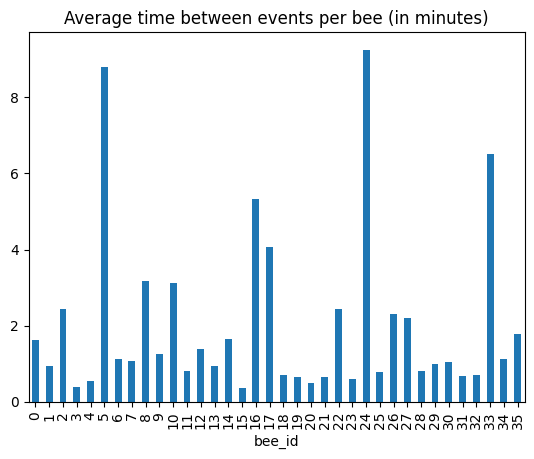

In [279]:
events = clustered.__deepcopy__()

# split points into short and long events based on clustering
events["event_id"] = events.apply(lambda row: f"short_{row.name}" if row.cluster == -1 else f"long_{row.cluster}", axis=1)

def event_dists(rows: pd.DataFrame):
    """calculate the distance from one event to the next, ignoring the internal distance within long events"""
    event_dists = []
    last_long_event = None
    
    row_iterator = rows.iterrows()
    _, last = next(row_iterator)  # take first item from row_iterator
    for i, row in row_iterator:

        if "short" in row.event_id:
            dist = row.timestamp - last.timestamp
            event_dists.append({
                "event_id": row.event_id,
                "dist": dist
            })
        else:
            if row.event_id == last_long_event:
                last_long_event = row.event_id
                continue
            else:
                last_long_event = row.event_id
                dist = row.timestamp - last.timestamp
                event_dists.append({
                    "event_id": row.event_id,
                    "dist": dist
                })
        last = row
        
    return pd.DataFrame(event_dists)


event_dists = events.groupby("bee_id").apply(event_dists)
avg_time_between_events_per_bee = event_dists.reset_index().groupby("bee_id").dist.mean() / np.timedelta64(1, 'm')
avg_time_between_events_per_bee.plot(kind="bar", title="Average time between events per bee (in minutes)")